# Wiki's Wacky Covid Factory

- This notebook presents the detailed methodology for the creation of our data story. 
- For a global overview, please look at our README.md
- For the datastory, clink the link in our repo!

### Libraries

In [81]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
import re
from bs4 import BeautifulSoup


# Antonio imports
from datetime import datetime, timedelta
from matplotlib.dates import AutoDateLocator, DateFormatter
import plotly.express as px
from pylab import  * 
import ast
from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf

from helpers.wiki_api_helpers import multi_lang_df, scrape_wikipedia_page, fetch_pageview_count, fetch_viewcount_df
from helpers.utils_helpers import spaces_to_underscore, read_csv_convert_list

from scipy import stats
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Part I**: Fake news on Wikipedia during the lockdown period, a useful tool?


- Action 0.1: Plot the global Wikipedia trends, including the mobility data.
- Goal: Show that during the studied period (first half of 2020), there was an increase in Wikipedia interest. Extract the trend using the Top 100 articles, as the data from the article itself is not long enough. (By WILLIAM)


In [ ]:
####### WILLIAM'S CODE #######

- Action 0.2: Use the difference-in-differences (DiD) method to determine whether the increase in interest towards articles related to fake news is statistically significant compared to the average article.
- Goal: Show that studying the rise of fake news through Wikipedia might be interesting using William's code with Antonio's code.


- Action 0.3 -> Zoom into COVID related articles (“COVID 19 misinformation”), and do dif in dif with regards to global trend
- Goal -> Show that studying the rise of COVID related fake news through wikipedia might be particularly interesting WILLIAM with Antonio’s code


### A) Lets extract the global trend of wikipedia articles

We want to identify the global trend of wikipedia articles and remove them from our viewcount analysis. From the wikipedia Top 25 report, we can get the list of the 100 most viewed wikipedia articles yearly.

We extract those and plot their total views between 2019 and 2022

In [17]:
file_paths = [
    'Data/top100_articles/topviews-2019.csv',
    'Data/top100_articles/topviews-2020.csv',
]

# Read the CSV files into dataframes
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Apply spaces_to_underscore function to the "Page" column of each dataframe
dataframes = [spaces_to_underscore(df, "Page") for df in dataframes]

# Useful dates
dates = [["20190101", "20191231"], ["20200101", "20201231"]]


In [ ]:
topviews_2019 = fetch_viewcount_df(df=dataframes[0], column="Page", language="en", start_date=dates[0][0], end_date=dates[0][1], granularity="daily")
topviews_2020 = fetch_viewcount_df(df=dataframes[1], column="Page", language="en", start_date=dates[1][0], end_date=dates[1][1], granularity="daily")

C:\Users\cpigu\AppData\Local\Temp\ipykernel_8956\3180845633.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topviews_grouped = topviews.groupby('timestamp').median()


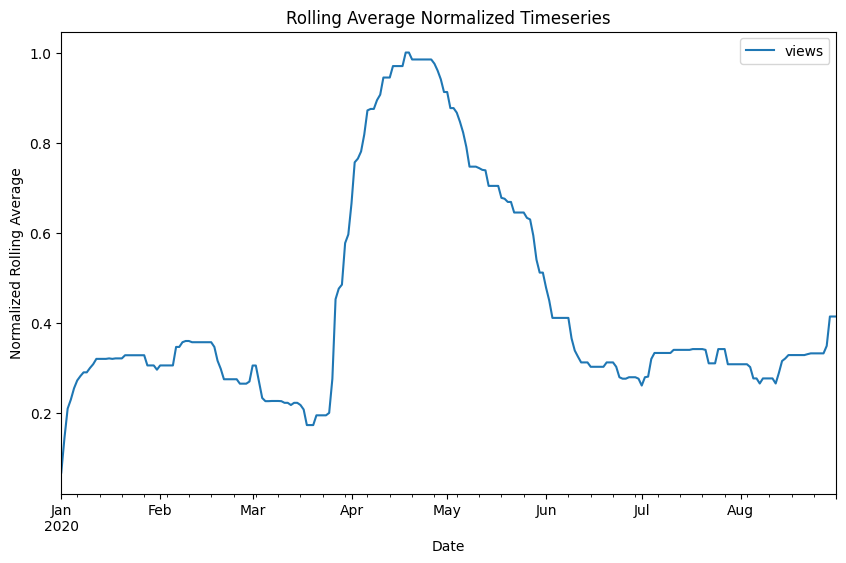

In [ ]:
start_date = "20200101"
end_date = "20200831"

topviews = pd.concat([topviews_2019, topviews_2020])
topviews_grouped = topviews.groupby('timestamp').median()
rolling_average = topviews_grouped.rolling(window=15, min_periods=1).median()
# Min-max normalization
rolling_average_normalized = (rolling_average - rolling_average.min()) / (rolling_average.max() - rolling_average.min())
rolling_average_normalized[start_date:end_date].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Normalized Rolling Average')
plt.title('Rolling Average Normalized Timeseries')
plt.show()


## **Part II**: COVID-19 misinformation, the relationship between media attention and Wikipedia pageviews

There are too many wikipedia articles, and too many ways of using the platform. Some people want to view articles as a way to confirm whether or not a fake news is fake, and some people might already be convinced and just want to feed their beliefs.

But that doesn't matter! Any interest is interesting for us, as they represent the emergence of viewing trends.

But first, we should be able to differentiate viewpage spikes which are fake news related, vs the normal trend...

#### Action 1.1
-	Action 1.1 -> Parse wikipedia “COVID 19 misinformation” page to obtain part names and sublinks. Group them according to the main topics of the wikipedia page (virus origin, incidence and mortality, disease spread, prevention, treatment, vaccine) PABLO
-	Goal -> Obtain a reliable group of articles directly related to COVID fake news
-	Add vaccine part


In [65]:
fetch_data = False
save_data = False
DATA_PATH = "./Data/dif_lang/"
if fetch_data:
    # Vaccine subpart correspond to another wikipedia article linked in the original COVID-19_misinformation article
    vaccine = scrape_wikipedia_page("COVID-19_vaccine_misinformation_and_hesitancy", language="en")
    en = scrape_wikipedia_page("COVID-19_misinformation", language="en")

    # Only keep the misinformation part of the article
    vaccine_misinformation = vaccine[vaccine['Main Heading'] == 'Misinformation'].copy()
    vaccine_misinformation.loc[vaccine_misinformation['Main Heading'] == 'Misinformation', "Main Heading"] = "Vaccine misinformation"
    
    ## add vaccine misinformation to en, en is a dataframe of all the misinformation
    en = pd.concat([en, vaccine_misinformation])

    # Remove the uninformative rows
    en = en[en['Main Heading'] != 'Other']
    en = en[en['Main Heading'] != 'Efforts to combat misinformation']
    
    if save_data:
        en.to_csv(DATA_PATH + "en.csv", index=False)
else:
    en = pd.read_csv(DATA_PATH + "en.csv")
    en['Full Links'] = en['Full Links'].apply(literal_eval)
    en['Links'] = en['Links'].apply(literal_eval)
    

In [71]:
en.head()

,Sub-subheading,Subheading,Main Heading,Links,Full Links
0,Wuhan lab origin,Wuhan lab origin,Virus origin,"[/wiki/COVID-19_lab_leak_theory, /wiki/Severe_...",[https://en.wikipedia.org/wiki/COVID-19_lab_le...
1,Bio-weapon,Wuhan lab origin,Virus origin,"[/wiki/Israeli_secret_service, /wiki/The_Washi...",[https://en.wikipedia.org/wiki/Israeli_secret_...
2,Gain-of-function research,Wuhan lab origin,Virus origin,"[/wiki/Gain-of-function_research, /wiki/Angela...",[https://en.wikipedia.org/wiki/Gain-of-functio...
3,Accidental release of collected sample,Wuhan lab origin,Virus origin,"[/wiki/Tedros_Adhanom_Ghebreyesus, /wiki/Scien...",[https://en.wikipedia.org/wiki/Tedros_Adhanom_...
4,Stolen from Canadian lab,Stolen from Canadian lab,Virus origin,"[/wiki/Health_Canada, /wiki/Public_Health_Agen...","[https://en.wikipedia.org/wiki/Health_Canada, ..."


#### Action 1.2
-	Action 1.2 -> Do a selection of articles representative for us, and process the data so that outliers (such as very big weight articles such as Donald Trump) are eliminated. One might also find a way to remove the global trend PABLO
-	Goal -> Make the graphs plotted with the sum of articles related to main categories representative of general interest


In [115]:
def fetch_and_aggregate_views(article_urls, start_date, end_date, granularity="monthly", aggregation='mean'):
    """
    Fetches views for a list of Wikipedia articles and aggregates them.

    Parameters:
    article_urls (list): List of Wikipedia article URLs.
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    granularity (str): Granularity of data ('daily', 'monthly', etc.).
    aggregation (str): Type of aggregation ('mean', 'median', 'sum').

    Returns:
    pd.DataFrame: DataFrame with dates as columns and aggregated view counts.
    """

    # Extract article titles from URLs
    article_urls = [url.split('/')[-1].replace('_', ' ') for url in article_urls]

    # Fetch pageview data for each article
    all_views = []
    for title in article_urls:
        print(title)
        # Assuming fetch_pageview_count is a function that fetches page view data for a given title
        views_data = fetch_pageview_count("en", title, start_date, end_date, granularity)
        all_views.append(views_data)

    # Combine all views into a single DataFrame
    combined_df = pd.concat(all_views)

    # Pivot the DataFrame to have dates as columns
    pivoted_df = combined_df.pivot_table(index='article', columns='date', values='views')

    # Aggregate the data
    if aggregation == 'mean':
        result_df = pivoted_df.mean()
    elif aggregation == 'median':
        result_df = pivoted_df.median()
    elif aggregation == 'sum':
        result_df = pivoted_df.sum()

    return result_df.transpose()


In [116]:
article_urls = en['Links'][0]
type(article_urls)

list

In [117]:
# Example usage
result_df = fetch_and_aggregate_views(article_urls, '20200101', '20201231', granularity='monthly', aggregation='mean')

COVID-19 lab leak theory
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Severe acute respiratory syndrome coronavirus 2
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 1. Status Code: 400
COVID-19
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 2. Status Code: 400
Error fetching data for 0. Status Code: 400
Error fetching data for 0. Status Code

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

#### Action 1.3
-	Action 1.3 -> Introduce the news dataset. Identify which news are directly related to the main categories through bag of words methods. What overlap is there?
-	Goal -> Find a link between media coverage and Wikipedia page visits TECLA
-	Interest overlap 


In [40]:
source  = "Data/"
main_df = pd.read_csv(source+"news_dataset_cl.csv").copy()
df2 = main_df[["news_id","statement","fact_url", "label", "lang", "time", "Cluster"]].copy()


In [60]:
languages_analyze = ["en", "es","pt", "fr", "it"]
count_news        = []
for i in languages_analyze:
    df_lang = pd.DataFrame(df2[df2["lang"]==i].groupby("time")["news_id"].count())
    df_new = df_lang.rename(columns={'news_id': i})
    count_news.append(df_new)
result  = pd.concat(count_news, axis=1)
results = result.fillna(0)   
df = results

# Convert the 'time' index to a datetime format
df['time_1'] = pd.to_datetime(df.index, format='%d/%m/%Y')

df = df.sort_values(by='time_1')
# Example usage:
language = "en"
articles_list = ["Covid-19"]
start_date = "20200101"
end_date = "20201101"
result=fetch_pageview_count(language, articles_list, start_date, end_date)

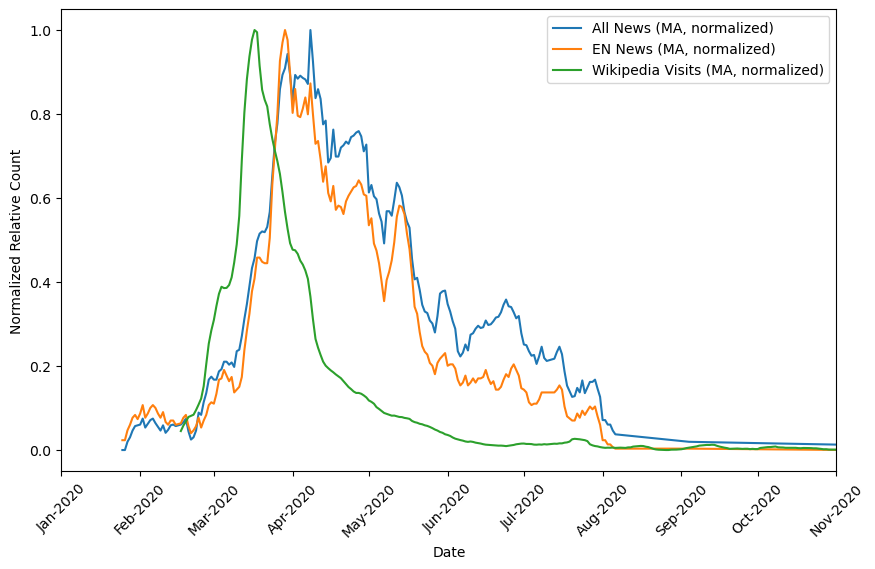

In [61]:
# Function to calculate moving average
def moving_average(series, window_size):
    return series.rolling(window=window_size).mean()

# Function for min-max normalization
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Assuming df is your DataFrame with the time series data

# Convert the 'time' index to a datetime format
df['time_1'] = pd.to_datetime(df.index, format='%d/%m/%Y')
df = df.sort_values(by='time_1')

# Define a window size for the moving average
window_size = 7  # Example: 7 for a weekly moving average

# Calculate moving averages and normalize
df_ma = df.copy()
df_ma['all_news_ma'] = min_max_normalize(moving_average(df[languages_analyze].sum(axis=1), window_size))
df_ma['en_news_ma'] = min_max_normalize(moving_average(df['en'], window_size))

# Assuming 'result' has the Wikipedia visits data structured correctly
# Normalize Wikipedia visits moving average
result_ma = result.copy()
result_ma["Covid-19"]["views_ma_norm"] = min_max_normalize(moving_average(result["Covid-19"]["views"], window_size))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['time_1'], df_ma['all_news_ma'], label="All News (MA, normalized)")
plt.plot(df['time_1'], df_ma['en_news_ma'], label="EN News (MA, normalized)")

# Uncomment the below line to plot normalized Wikipedia visits (if structured correctly)
plt.plot(result["Covid-19"]["timestamp"], result_ma["Covid-19"]["views_ma_norm"], label="Wikipedia Visits (MA, normalized)")

plt.xlabel('Date')
plt.ylabel('Normalized Relative Count')
plt.xlim(datetime(2020, 1, 1), datetime(2020, 11, 1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()


-	Action 1.4 -> Plot the final curves of news articles published vs wikipedia articles interest. Is there a correlation? PABLO + TECLA
-	Goal -> Study the relationship between media attention/Coverage and Wikipedia views
-	Statistical test to prove that? Jackart similarity of the different curves


### C) Identifying relevant articles from view count analysis

Not all the articles clustered are relevant for our research (ex: For the Virus Origine: Bio-weapon, we have a set of articles but some are connected to the topic but as relevant like Steve Bannon we need to remove them for the analysis !) Donald Trump is also a good example of course he is related to the spread of some covid news but he has some sipkes of views going up to 1 million and a constant view count of 50k the apparition of a fakenews might increase that constant number up to 52k a small spike but not noticeable in comparaison to the spike of 1m we won't be able to notice that increase unfortunatly. For the sake of the view_count need to remove it ! Since we have a lot of articles about a Topic we can remove thoses articles without affecting too much the topic total view count of the relevat articles.

 But how can we do it ?



The wikiTopic is a class having all th enecesaary information for a specific Main Heading topic.

### Manual search

In [177]:
def getSelectedArticlesFromViews(topic):
        
    # Existing features
    articlesName = []

    maxi = []
    stkew = []
    kurt = []

    for i in range(len(topic.dfView)):
        views_data = topic.dfView[i]["views"]

        articlesName.append(topic.dfView[i].article.unique()[0])
        
        maxi.append(np.max(views_data))
        stkew.append(stats.skew(views_data))
        kurt.append(stats.kurtosis(views_data))

    labelOfKey = pd.DataFrame()
    labelOfKey["key"] = articlesName
    labelOfKey["maxi"] = maxi
    labelOfKey["skew"] = stkew
    labelOfKey["kurt"] = kurt
    

    return labelOfKey, labelOfKey[(labelOfKey["skew"] < 3) & (labelOfKey["maxi"] < 50000) & (labelOfKey["kurt"] < 15)]
    

In [8]:
df_fakecovidNews = pd.read_excel("./Data/en_clean_excel.xlsx")

In [184]:
class wikiTopic:
    df = [] #dataframe of the all the topic

    links = [] #list of links of the topic
    dfView = [] #list of the differents views for each links
    dfViewFinal = [] #list of the differents views for each links that existed during the pandemic period 

    featureInfo = [] #list 

    selectArticles = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

        self.featureInfo, self.selectArticles  = getSelectedArticlesFromViews(self)

    def extractLinksFromDf(self): #extract all the links related to a Topic

        linksFinal = []
        for links in self.df.Links:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):  #fetch view counts of all the links
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])


def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link, "20200101", "20200630")
        if(len(result) != 0):
            views.append(result)

    return views[0]


In [179]:
topic = wikiTopic(df_fakecovidNews, "Virus origin")

Error fetching data for "2022_German_coup_détat_plot". Status Code: 404
Error fetching data for Mark_Steele_(conspiracy_theorist). Status Code: 404
Error fetching data for Biosafety_level#Biosafety_level_4. Status Code: 404
Error fetching data for List_of_conspiracy_theories#RFID_chips. Status Code: 404
Error fetching data for Chimeric_virus. Status Code: 404
Error fetching data for 2022_Russian_invasion_of_Ukraine. Status Code: 404
Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404
Error fetching data for _Russia. Status Code: 404
Error fetching data for Li-Meng_Yan. Status Code: 404
Error fetching data for Kate_Shemirani. Status Code: 404
Error fetching data for COVID-19_lab_leak_theory. Status Code: 404
Error fetching data for Gain-of-function_research. Status Code: 404
Error fetching data for Anti-vaccine_activism. Status Code: 404
Error fetching data for COVID-19_misinformation_by_China. Status Code: 404


From the links we manual a small set of articles and we are looking for a way to discociate the relevant from the irrelevant articles. I did this classfication by reading the Bio-Weapons part on the wikipedia page. And by selecting manually the articles about the subject. We tried to avoid the articles too general (The_Washington_Times', 'Chinese_Communist_Party') on thoses articles there are too  many cofounders...

We also tried to avoid having personalities talking about a subject because again too many cofounders except if they are only famouse for a specific case of the Bio-Weapon (in this case)

In [163]:
MMethod = {
    'Israeli_secret_service': 1,
    'The_Washington_Times': 0,
    'Biosafety_level_4': 1,
    'Wuhan_Institute_of_Virology': 1,
    'Preprint': 1,
    'Steve_Bannon': 0,
    'Guo_Wengui': 0,
    'Expatriate': 0,
    'Anti-Chinese_sentiment': 1,
    'Echo_chamber_(media)': 1,
    'Plandemic': 1,
    'The_Epoch_Times': 0,
    'Chinese_Communist_Party': 0,
    'Falun_Gong': 1,
    'Severe_acute_respiratory_syndrome_coronavirus_2': 0,
    'Fort_Detrick': 0,
    'Andrew_Bridgen': 0
}

MMethodeNames = list(MMethod.keys())
MMethodeValues = list(MMethod.values())

DFViewMMethod = []

for i in range(len(topic.dfView)):
    currentDFView = topic.dfView[i]

    if(currentDFView.article.unique()[0] in MMethod.keys()):
        DFViewMMethod.append(currentDFView)

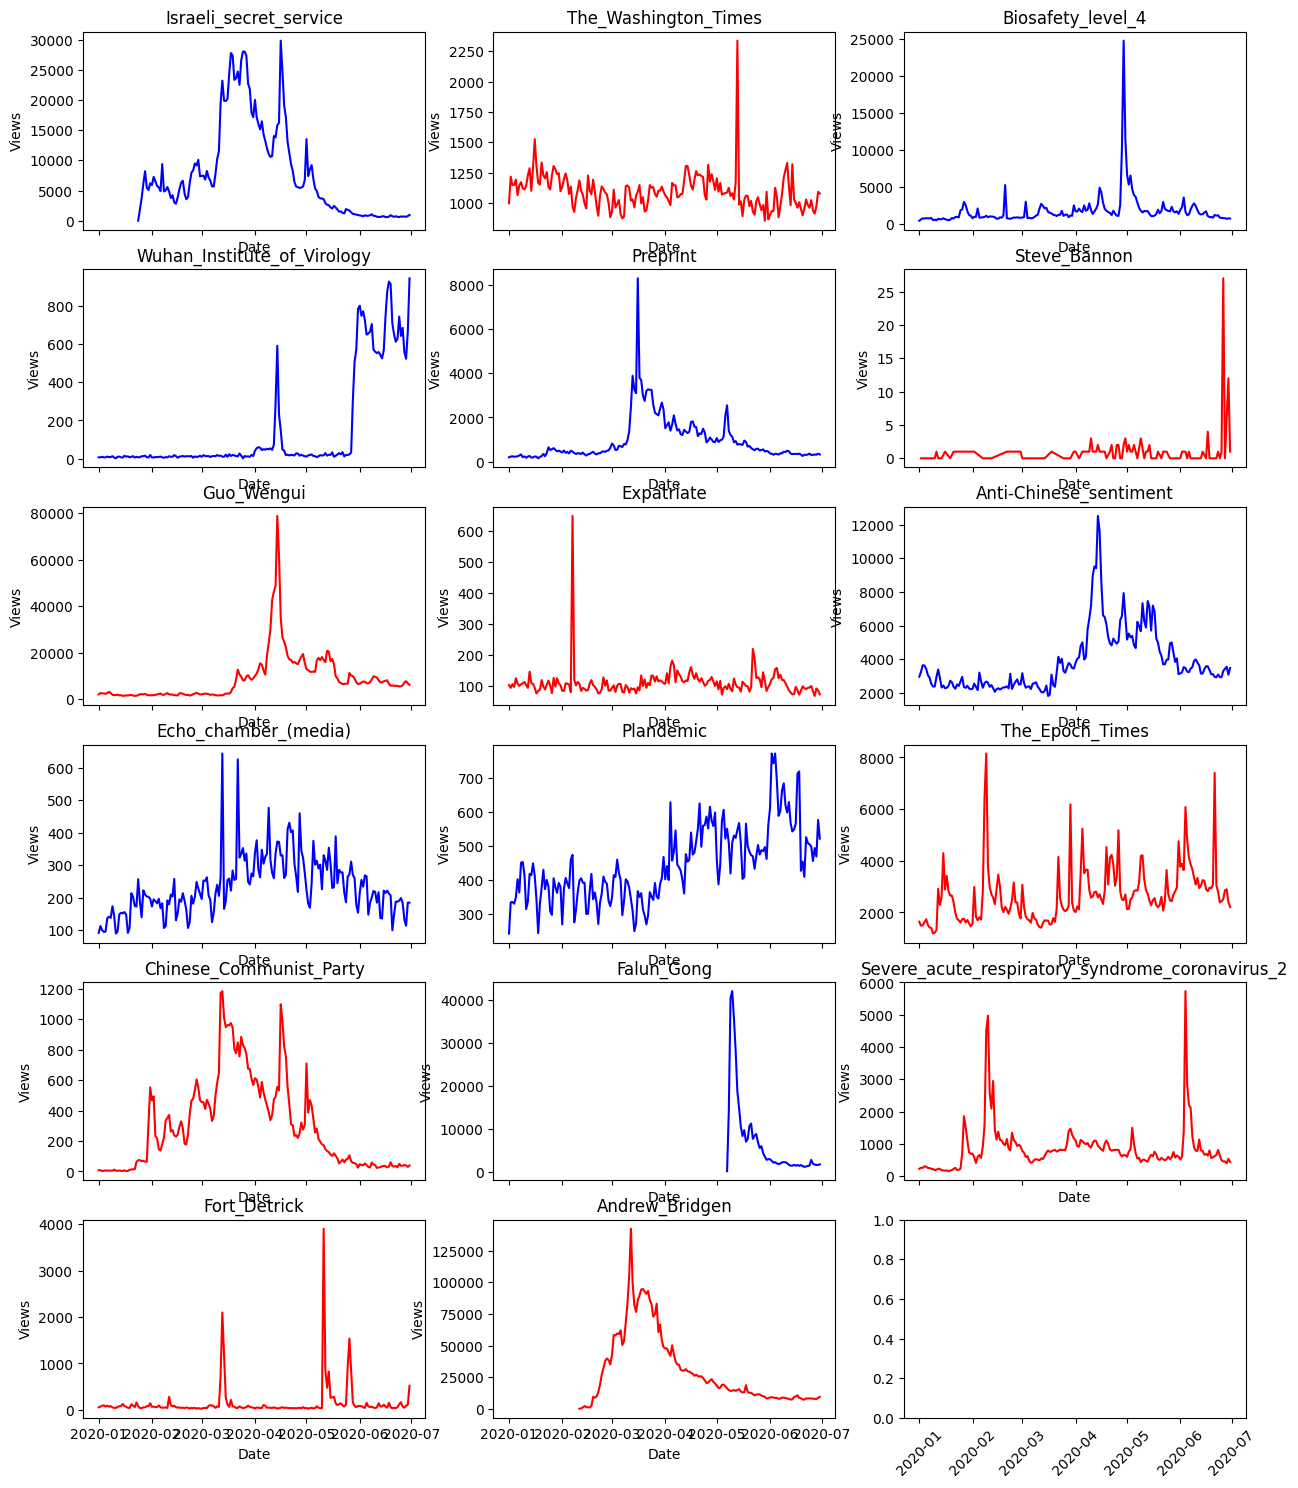

In [160]:
fig, axs = plt.subplots(len(DFViewMMethod)//3 + 1, 3, figsize=(15, len(DFViewMMethod)+1), sharex=True)
for i in range(len(DFViewMMethod)):
    plt.xticks(rotation=45)
    axs[i//3, i%3].plot(list(DFViewMMethod[i]["timestamp"]), (DFViewMMethod[i]['views']), color='blue' if MMethodeValues[i] == 1 else 'red')
    axs[i//3, i%3].set_title(MMethodeNames[i])

    axs[i//3, i%3].set_ylabel('Views')
    axs[i//3, i%3].set_xlabel('Date')

We need to find a distrinction between the red and blue curves. We are trying to find those infos (high spike in attention, low attention pre lockdown, higher attention after lockdown)

This allowed for an efficient selection of articles directly related to Fake news topics based on [Skewness](https://en.wikipedia.org/wiki/Skewness), Max Views and the [Kurtosis metric](https://en.wikipedia.org/wiki/Kurtosis) and some extra features to test.

In [161]:
labelOfKey = pd.DataFrame()
labelOfKey["key"] = MMethod.keys()
labelOfKey["label"] = MMethod.values()

mean = []
median = []
std = []
maxi = []
mini = []
stkew = []
kurt = []
range_val = []

for current_DFViewMMethod in DFViewMMethod:

    views_data = current_DFViewMMethod['views']

    mean.append(np.mean(views_data))
    median.append(np.median(views_data))
    std.append(np.std(views_data))
    maxi.append(np.max(views_data))
    mini.append(np.min(views_data))
    stkew.append(stats.skew(views_data))
    kurt.append(stats.kurtosis(views_data))
    range_val.append(np.ptp(views_data))  # Range


labelOfKey["max"] = maxi
labelOfKey["skew"] = stkew
labelOfKey["kurt"] = kurt
labelOfKey["mean"] = mean
labelOfKey["median"] = median
labelOfKey["range"] = range_val
labelOfKey["std"] = std
labelOfKey["min"] = mini

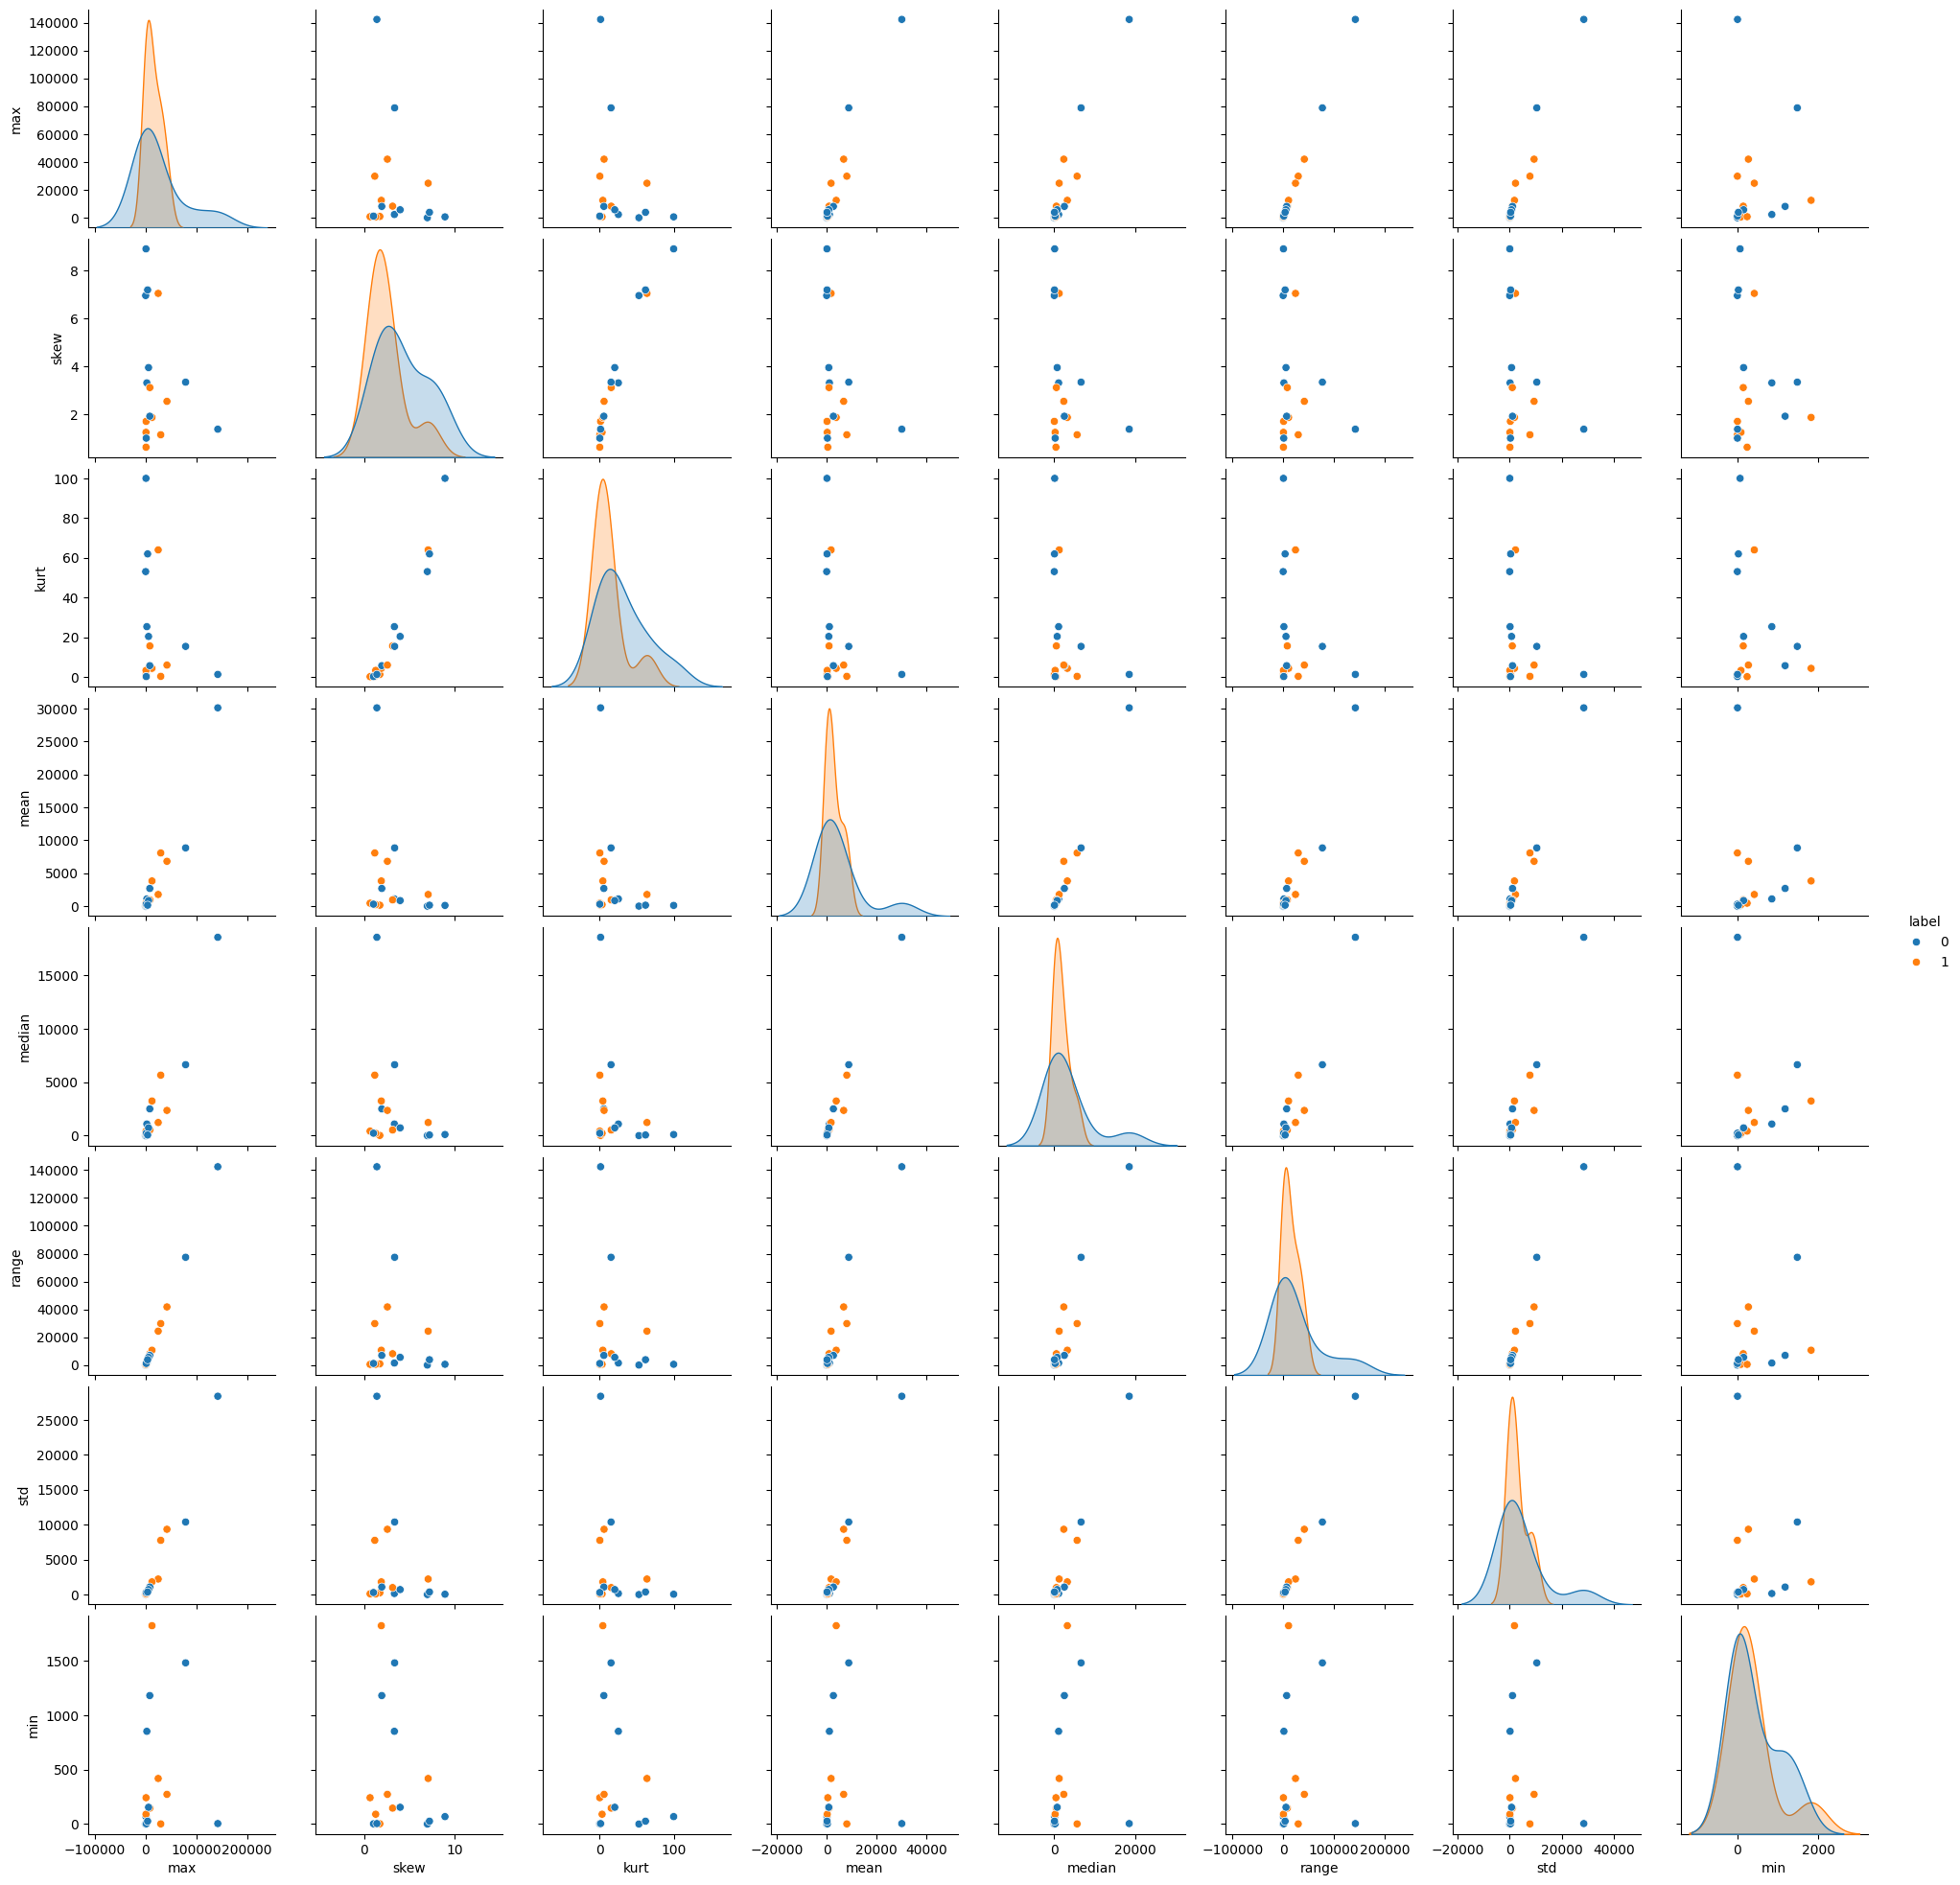

In [162]:
sns.pairplot(labelOfKey, hue="label")

By looking at the data we can start to make some assumptions to separate the :

- "skew" < 3
- "maxi" < 50000
- "kurt" < 15

### Apply to the whole dataset

In [185]:
for k in range(0, len(df_fakecovidNews["Main Heading"].unique())):
    currentHeading = df_fakecovidNews["Main Heading"].unique()[k]
    topic = wikiTopic(df_fakecovidNews, currentHeading)

    allSelectedArticles = list(topic.selectArticles.key)

    
    processedLinks = []

    for link in df_fakecovidNews[df_fakecovidNews["Main Heading"]==currentHeading]["Links"]:
        link = link[1:-1]
        link = link.split(',')
        link = [re.sub(r'[\[\]\'\s]', '', link) for link in link]
        link = [re.sub(r'/wiki/', '', link) for link in link]
        processedLinks = processedLinks + [link]


    finalSelectedArticles = []
    for i in range(len(processedLinks)):
        selectedRow = []
        for j in range(len(processedLinks[i])):
            if(processedLinks[i][j] in allSelectedArticles):
                selectedRow.append(processedLinks[i][j])
        
        finalSelectedArticles.append(selectedRow)

    finalSelectedArticlesToString = []

    for i in range(len(finalSelectedArticles)):
        finalSelectedArticlesToString.append("', '".join(finalSelectedArticles[i]))
        finalSelectedArticlesToString[i] ="['" + finalSelectedArticlesToString[i] + "']"


    mask = df_fakecovidNews["Main Heading"] == currentHeading
    df_fakecovidNews.loc[mask, "clean_articles"] = finalSelectedArticlesToString
            




Error fetching data for "2022_German_coup_détat_plot". Status Code: 404
Error fetching data for Mark_Steele_(conspiracy_theorist). Status Code: 404
Error fetching data for Biosafety_level#Biosafety_level_4. Status Code: 404
Error fetching data for List_of_conspiracy_theories#RFID_chips. Status Code: 404
Error fetching data for Chimeric_virus. Status Code: 404
Error fetching data for 2022_Russian_invasion_of_Ukraine. Status Code: 404
Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404
Error fetching data for _Russia. Status Code: 404
Error fetching data for Li-Meng_Yan. Status Code: 404
Error fetching data for Kate_Shemirani. Status Code: 404
Error fetching data for COVID-19_lab_leak_theory. Status Code: 404
Error fetching data for Gain-of-function_research. Status Code: 404
Error fetching data for Anti-vaccine_activism. Status Code: 404
Error fetching data for COVID-19_misinformation_by_China. Status Code: 404


Some reformatting

In [187]:
sArray = []
for i in range(len(df_fakecovidNews)):
    array = df_fakecovidNews.iloc[i].clean_articles[2:-2].split("', '")

    if array[0] == '':
        s = ""
    else:
        s = "['" + "', '".join(['/wiki/' + item for item in array]) + "']"

    sArray.append(s)

df_fakecovidNews.loc[:,"clean_articles"] = sArray[:]

And there's we go we have a new column with the healthy articles. We will be using that column from now on !

## **Part III**: Multilingual analysis of COVID-19 misinformation


-	Action 2.1 -> How did people’s fake news focus evolve with mobility? More interest in spread? In politics and stuff? VICTOR
-	Goal -> Study link between mobility restrictions and fake news interest


-	Action 2.2 -> Study “Covid 19 misinformation” pages for other languages as well. Extract the subparts and classify them into the same 5 main categories as the english one VICTOR
-	Goal -> Obtain the same dataset for other languages


In [143]:
fetch_data = False
save_data = False
DATA_PATH = "./Data/dif_lang/"
languages = ['fr', 'es', 'ar', 'zh', 'pt', 'de', 'ru', 'it']
if fetch_data:
    url = "https://en.wikipedia.org/wiki/COVID-19_misinformation" # Reference URL
    # Gets equivalent URL of reference URL in other languages
    # Then parses the relevant wiki pages (Main Heading, Sub Headings, Subsubheadings, Links)
    # Then translation we translate the subparts, and equivalent english links are added to the dataframe
    headings_df = multi_lang_df(url, languages) 

    if save_data:
        for lang in languages:
            headings_df[lang].to_csv(DATA_PATH + lang + ".csv", index=False)
else:
    en_col_links = ["Links", "Full Links"]
    otr_lang_col_links = ["Links", "Full Links", 'English Full Links', 'English Relative Links']
    en = read_csv_convert_list(DATA_PATH + "en.csv", en_col_links)

    for lang in languages:
        #Create a dataframe for each of the languages
        globals()[lang] = read_csv_convert_list(DATA_PATH + lang + ".csv", otr_lang_col_links)
    

In [101]:
def aggregate_urls(dataframes, url_column):
    """
    Aggregates URLs from multiple dataframes and creates a one-hot encoded matrix.

    :param dataframes: List of DataFrames to process.
    :param url_column: Name of the column containing URLs.
    :return: A one-hot encoded DataFrame.
    """
    # Collecting all URLs in a set to avoid duplicates
    all_urls = set()
    for df in dataframes:
        for urls in df[url_column]:
            all_urls.update(urls)

    # Creating a dictionary to hold one-hot encoding
    one_hot_dict = {url: [0] * len(dataframes) for url in all_urls}

    # Filling the dictionary with one-hot encoding
    for i, df in enumerate(dataframes):
        for urls in df[url_column]:
            for url in urls:
                if url in one_hot_dict:
                    one_hot_dict[url][i] = 1

    # Creating a DataFrame from the dictionary
    one_hot_df = pd.DataFrame.from_dict(one_hot_dict, orient='index', columns=[f'DF{i+1}' for i in range(len(dataframes))])

    return one_hot_df


In [147]:
en = en.rename(columns={'Full Links': 'English Full Links'})


In [149]:
OH = aggregate_urls([ru,zh,de,ar,en,es,fr,it,pt], "English Full Links")

In [165]:
import pandas as pd
from itertools import combinations

def calculate_overlap_between_dataframes(df):
    """
    Calculate the overlap in URLs between each pair of DataFrame columns.

    :param df: DataFrame with URLs as rows and one-hot encoded columns representing different DataFrames.
    :return: DataFrame with overlap counts between each pair of original DataFrames.
    """
    overlap_data = []

    # Create a mapping of column names to indices
    col_name_to_index = {col: idx for idx, col in enumerate(df.columns)}

    # Iterate over all combinations of DataFrame columns
    for (col1, col2) in combinations(df.columns, 2):
        overlap_count = sum(df[col1] & df[col2])
        if overlap_count > 0:
            overlap_data.append({
                'source': col_name_to_index[col1], 
                'target': col_name_to_index[col2], 
                'value': overlap_count
            })

    return pd.DataFrame(overlap_data)


In [167]:
overlap_df = calculate_overlap_between_dataframes(OH)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
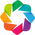

In [172]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)

data = {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'name': ['Russian','Chinese','German','Arabic','English','Spanish','French','Italian','Portuguese'],
    'group': [1, 1, 2, 3, 2, 2, 2, 2, 4]}

In [185]:
# Create dataframe
df = pd.DataFrame(data)

# Print dataframe
print(df)


   index        name  group
0      0     Russian      1
1      1     Chinese      1
2      2      German      2
3      3      Arabic      3
4      4     English      2
5      5     Spanish      2
6      6      French      2
7      7     Italian      2
8      8  Portuguese      4


In [186]:
nodes = hv.Dataset(df, 'index')
nodes.data.head()

,index,name,group
0,0,Russian,1
1,1,Chinese,1
2,2,German,2
3,3,Arabic,3
4,4,English,2


In [184]:
chord = hv.Chord((overlap_df, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

:Chord   [source,target]   (value)

-	Action 2.3 -> Overlap of news topics between languages
-	Compare those results with wikipedia node graph of overlap of wiki articles per category


-	Action 2.4 -> Find a way to represent the interactions between the different languages -> Plot the interest curves? 
-	Timeseries, Venn diagram, node thing?
